In [491]:
import os
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

import tensorflow as tf

Helper functions to create a model

In [492]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x


# Using this (with_EGGNOG) for warm-starting prototype. The following names (conv*) match with model.h5 file's names.
def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d_EGGNOG" % branch)
    
    return x


def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d_EGGNOG" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d_EGGNOG" % (stage, branch))
    
    return x

Create keras model and load weights

In [619]:
# test and loss calc
eggnog_testing = True
shoulder_last = False
hm_npy_dir = "/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/test_out/o1/"

base_dir = "/s/red/b/nobackup/data/eggnog_cpm/training_files/common_train/0706180300pm"
weights_path = base_dir + "/training/weights_egg/weights_egg.0050.h5" # original weights converted from caffe
# weights_path = "training/weights.best.h5" # weights trained from scratch 
# print(os.getcwd())

branch_flag = 2

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 2
np_branch1 = 18
np_branch2 = 11

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)

# VGG
stage0_out = vgg_block(img_normalized)

if branch_flag == 0:  # heatmaps and pafs both
    # stage 1
    stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
    stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
    x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

    # stage t >= 2
    for sn in range(2, stages + 1):
        stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
        stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
        if (sn < stages):
            x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])
    
    model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
    model.load_weights(weights_path)

elif branch_flag == 2:  # heatmaps only
    # stage 1
    stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
    x = Concatenate()([stage1_branch2_out, stage0_out])

    # stage t >= 2
    for sn in range(2, stages + 1):
        stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
        if (sn < stages):
            x = Concatenate()([stageT_branch2_out, stage0_out])
            
    model = Model(img_input, [stageT_branch2_out])
    model.load_weights(weights_path)

else:
    raise NotImplementedError("Only paf network is not implemented")

Load a sample image

In [620]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

len(test_imgs) 351
test_image_path /s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm/s18/part2_layouts_p35/20160129_195318_00_Video/20160129_195318_00_Video_vfr_82_skfr_79_240x320.jpg
oriImage shape (240, 320, 3)
(240, 320, 3)


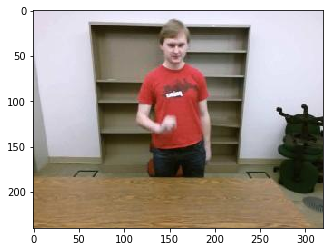

In [621]:
test_dir = '/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm/s18/part2_layouts_p35/20160129_195318_00_Video/'
# "/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/s05/part1_layout_p10/20151114_014811_00_Video/" 
# '/s/chopin/k/grad/guru5/red-b/data/eggnog_cpm/eggnog_cpm_test/test_set/20160129_192551_00_Video_version2/' 
test_imgs = [im for im in os.listdir(test_dir) if im.endswith(".jpg")]

print("len(test_imgs)", len(test_imgs))  #, test_imgs)

img_idx = 10


# test_image = 'sample_images/ski1.jpg'
test_image = os.path.join(test_dir, test_imgs[img_idx])

print("test_image_path", test_image)

oriImg = cv2.imread(test_image)  # B,G,R order
print("oriImage shape", oriImg.shape)
plt.imshow(oriImg[:,:,::-1])
print(oriImg.shape)

# if eggnog_testing:  # use RGB order for now (6/26)
#     oriImg = oriImg[:, :, ::-1]  # BGR to RGB

Load configuration

In [622]:
param, model_params = config_reader()
eggnog_h = 240

if not eggnog_testing:
    multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
else:
    multiplier = [x * eggnog_h / oriImg.shape[0] for x in param['scale_search']]
print("multiplier", multiplier)

multiplier [0.5, 1.5, 2.0, 1.0]


Show sample heatmaps for right elbow and paf for right wrist and right elbow

scale ==================== 0.5
imageToTest.shape (120, 160, 3)
imageToTest_padded.shape (120, 160, 3)
Input shape: (1, 120, 160, 3)
Output shape: 1
after squeeze heatmap (15, 20, 11)
saving /s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/test_out/o1/20160129_195318_00_Video_vfr_82_skfr_79_240x320_egg_test_True_m_hm.npy heatmap.shape (15, 20, 11)
after resize heatmap (120, 160, 11)
after removing padding heatmap (120, 160, 11)
scale ==================== 1.5
imageToTest.shape (360, 480, 3)
imageToTest_padded.shape (360, 480, 3)
Input shape: (1, 360, 480, 3)
Output shape: 1
after squeeze heatmap (45, 60, 11)
saving /s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/test_out/o1/20160129_195318_00_Video_vfr_82_skfr_79_240x320_egg_test_True_m_hm.npy heatmap.shape (45, 60, 11)
after resize heatmap (360, 480, 11)
after removing padding heatmap (360, 480, 11)
scale ==================== 2.0
imageToTest.shape (480, 640, 3)
imageToTest_padded.shape (480, 640, 3)
Input shape: (1, 480, 640, 3)
Outp

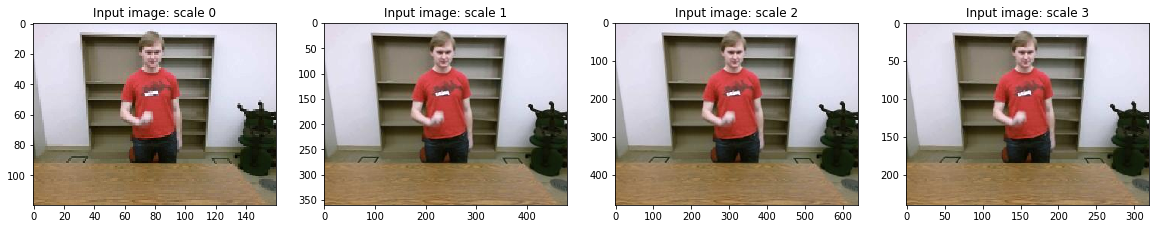

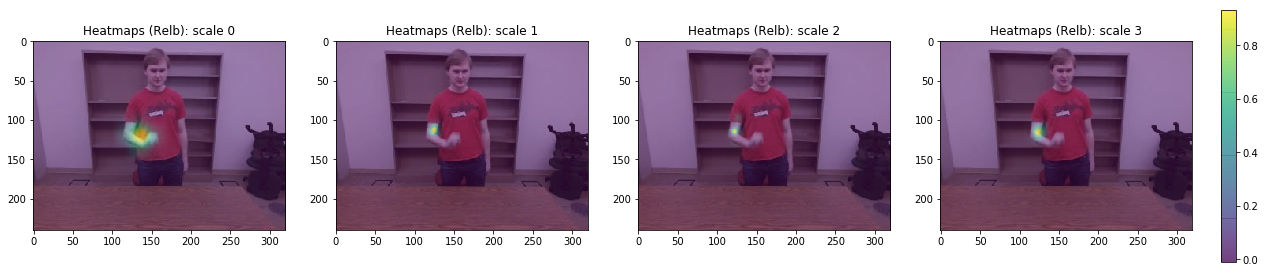

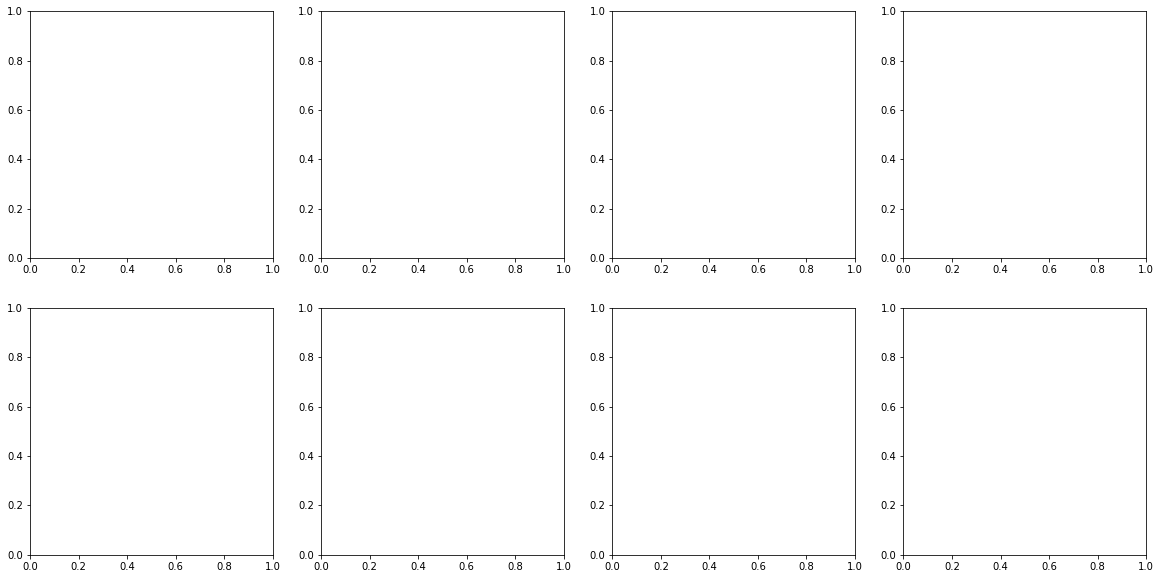

In [623]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 11))
# paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))

for m in range(len(multiplier)):
    scale = multiplier[m]
    print("scale ====================", scale)
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    print("imageToTest.shape", imageToTest.shape)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    print("imageToTest_padded.shape", imageToTest_padded.shape)
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    print("Output shape: " + str(len(output_blobs)))
    # print("Output shape (PAF?): " + str(output_blobs[0].shape))
    # print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[0]) # output 0 is heatmaps for L2 only network
    print("after squeeze heatmap", heatmap.shape)
    
    # save to disk
    hm_savefile = os.path.join(hm_npy_dir, test_image.split("/")[-1].split(".")[0] + "_egg_test_" + str(eggnog_testing) + "_m" + "_hm.npy") 
    np.save(hm_savefile, heatmap)
    print("saving", hm_savefile, "heatmap.shape", heatmap.shape)
    
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    print("after resize heatmap", heatmap.shape)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    print("after removing padding heatmap", heatmap.shape)
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
#     paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
#     paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
#     paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
#     paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])  # BGR to RGB
    ax2 = axarr2[m].imshow(heatmap[:,:,3], alpha=.5) # right elbow index 3
    axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
    
#     axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
#     ax3x = axarr3.flat[m].imshow(paf[:,:,16], alpha=.5) # right elbow index 3
#     axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
#     axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
#     ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,17], alpha=.5) # right wrist
#     axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
#     paf_avg = paf_avg + paf / len(multiplier)

    
f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

# f3.subplots_adjust(right=0.93)
# cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
# _ = f3.colorbar(ax3x, cax=cbar_axx)
# cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
# _ = f3.colorbar(ax3y, cax=cbar_axy)

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

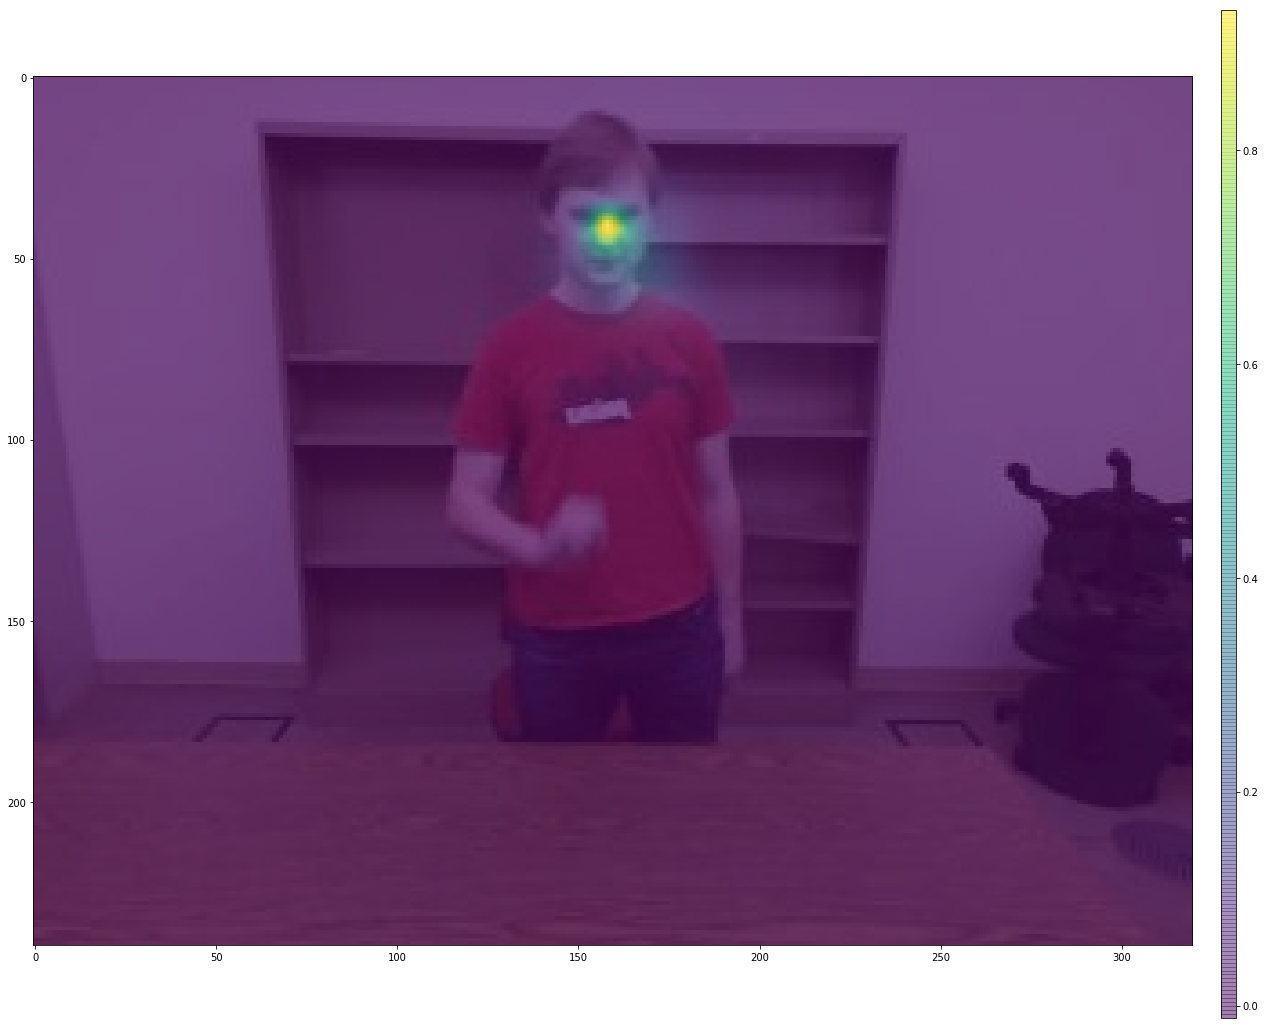

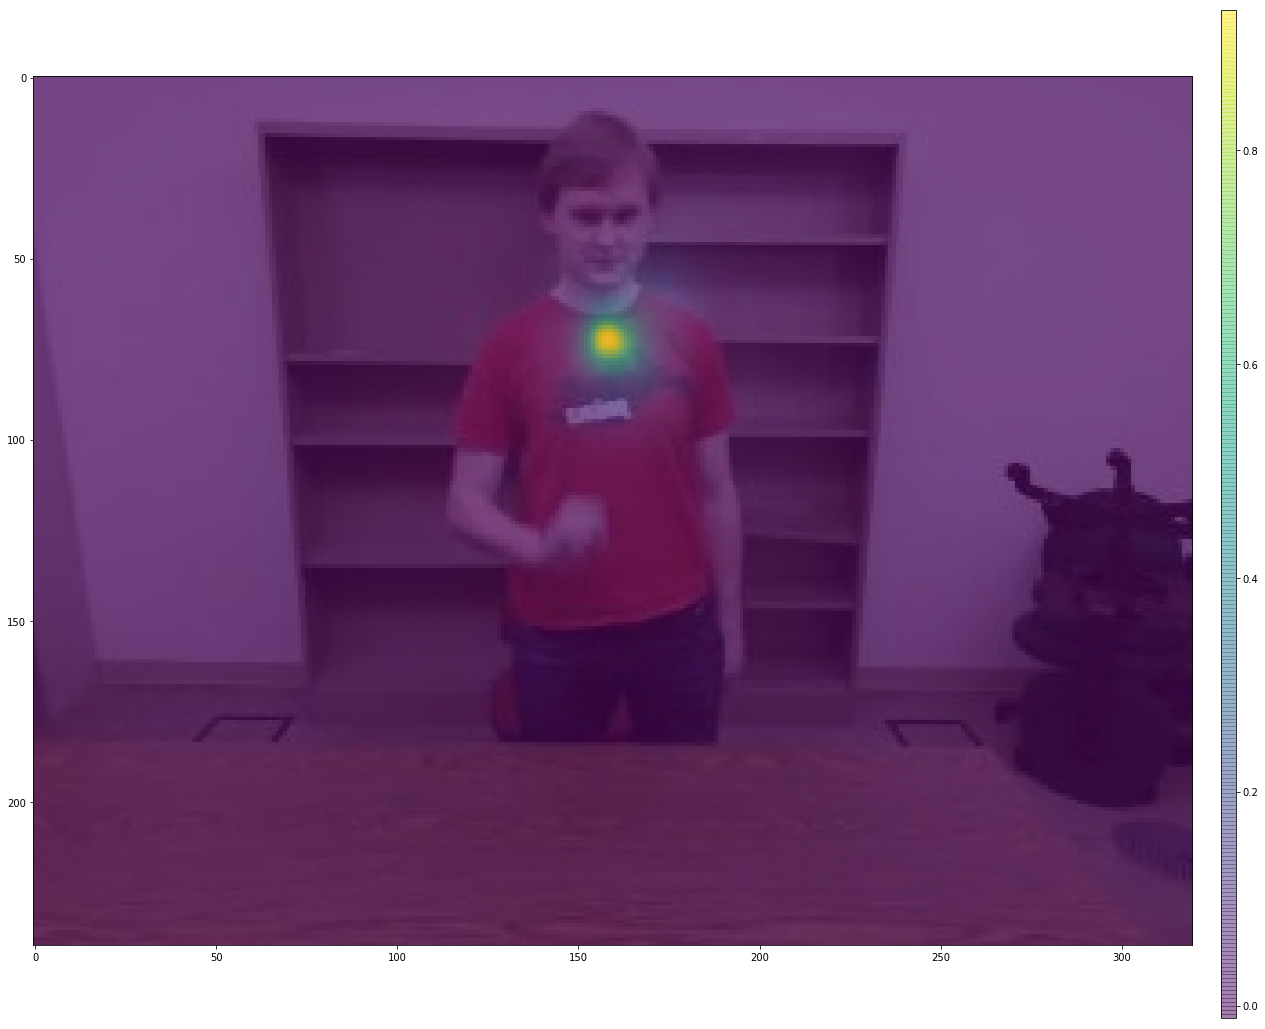

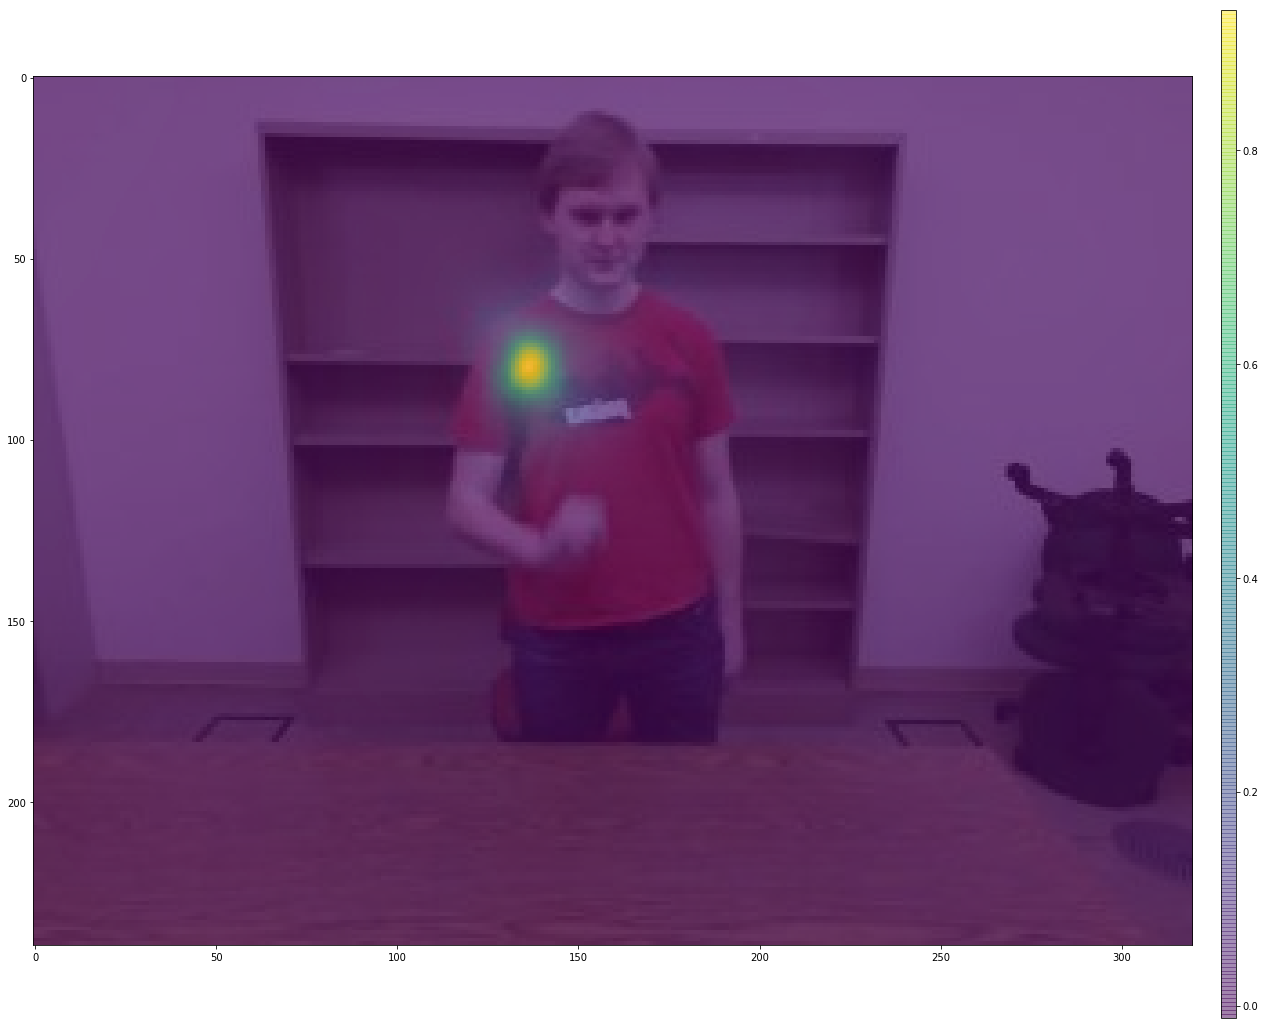

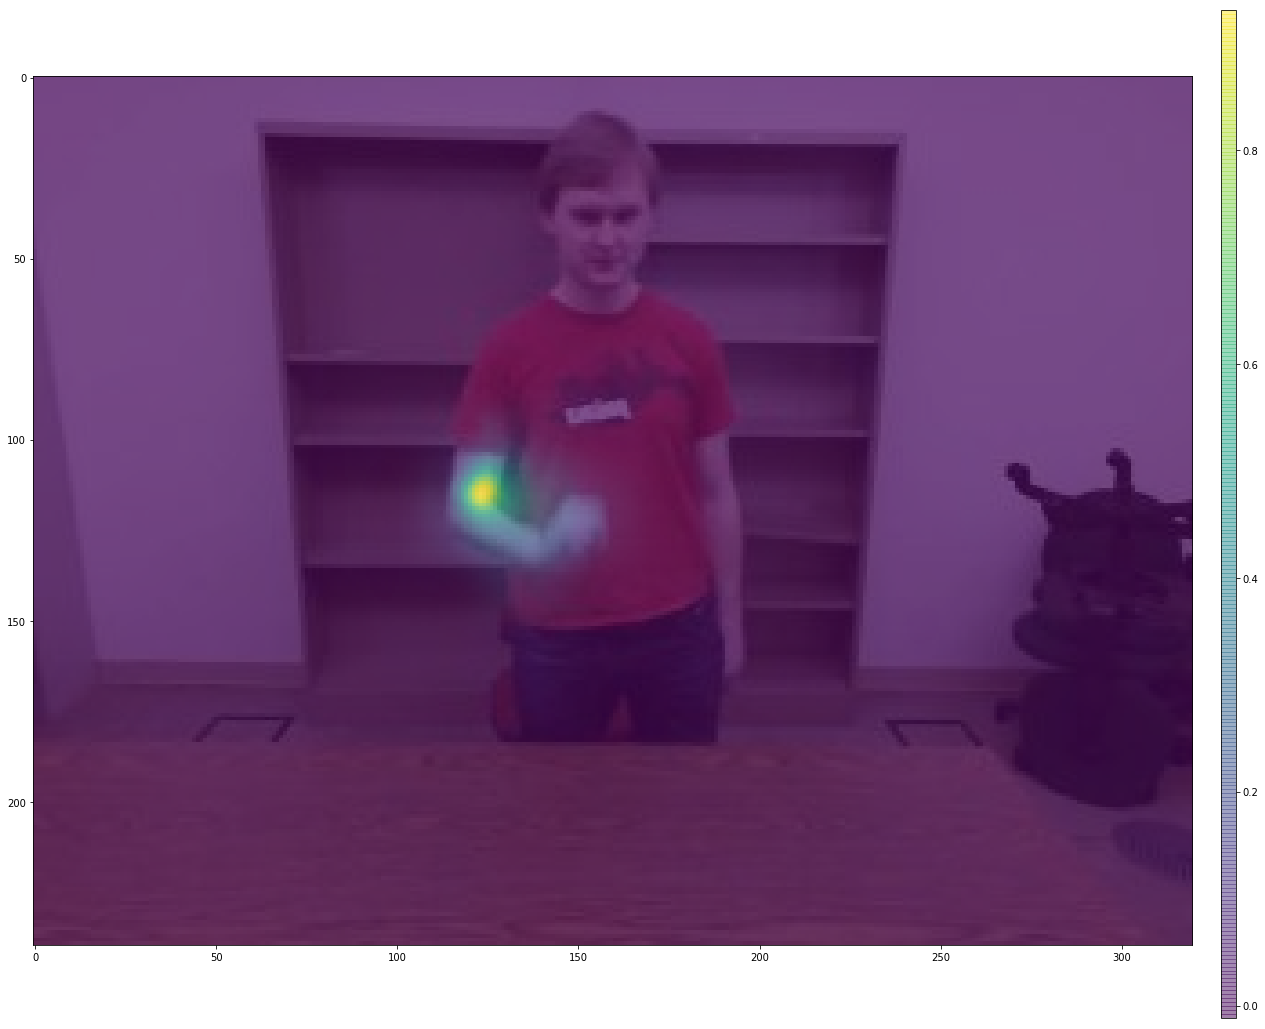

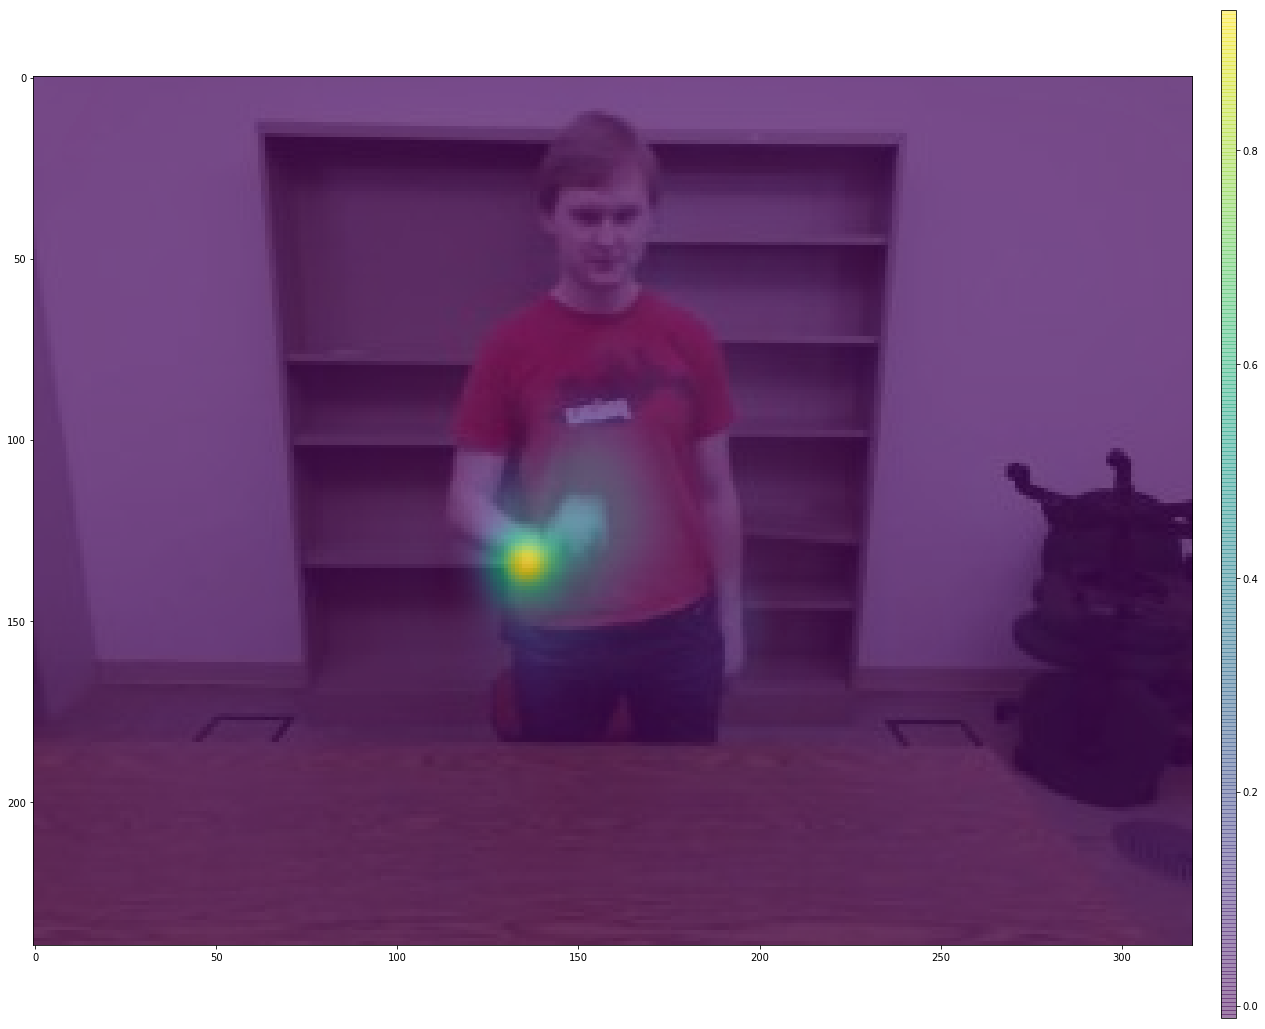

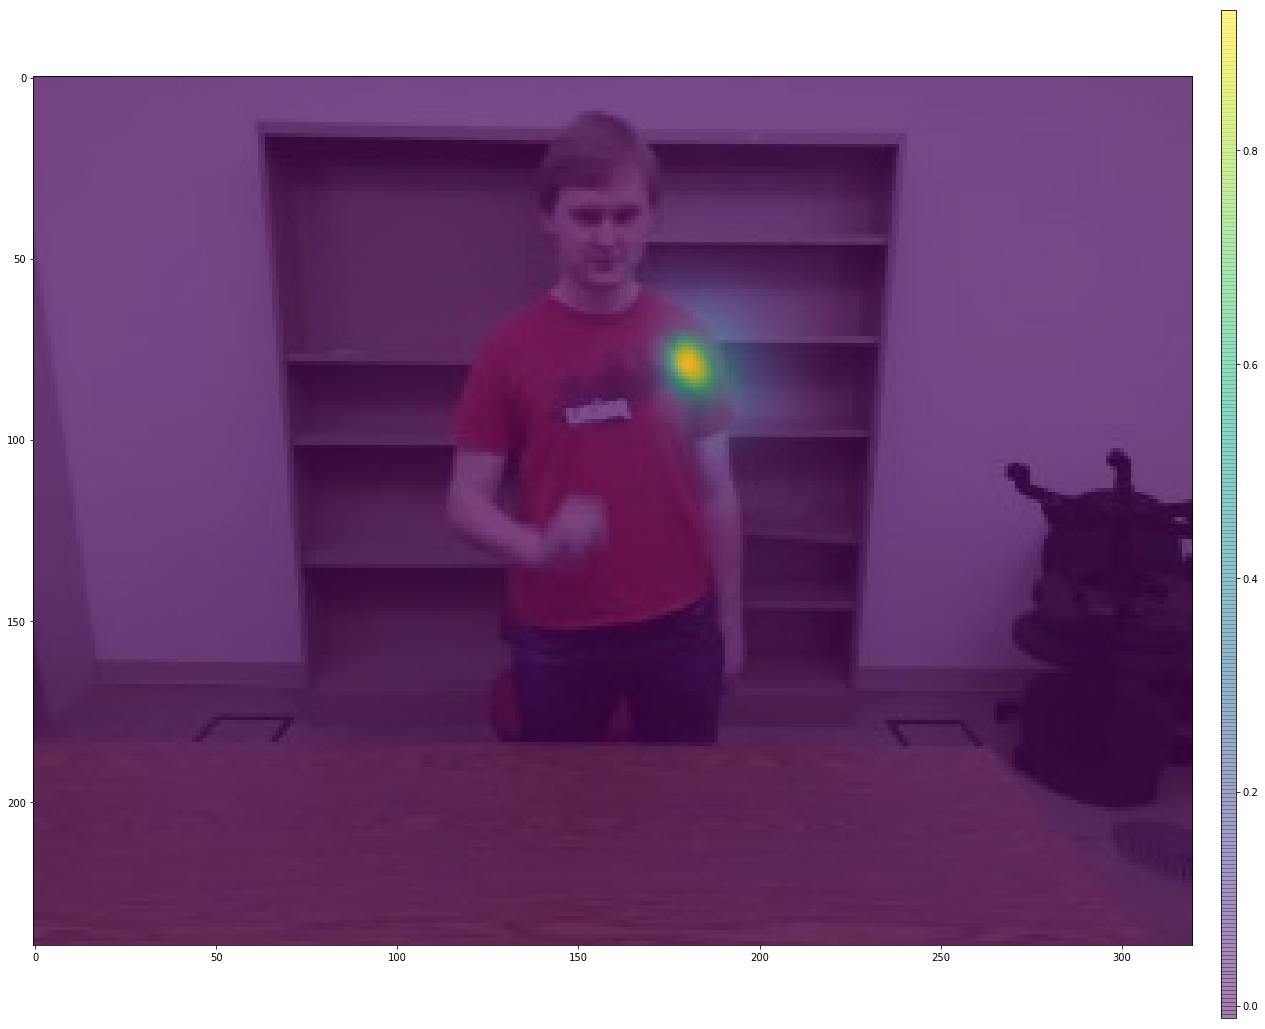

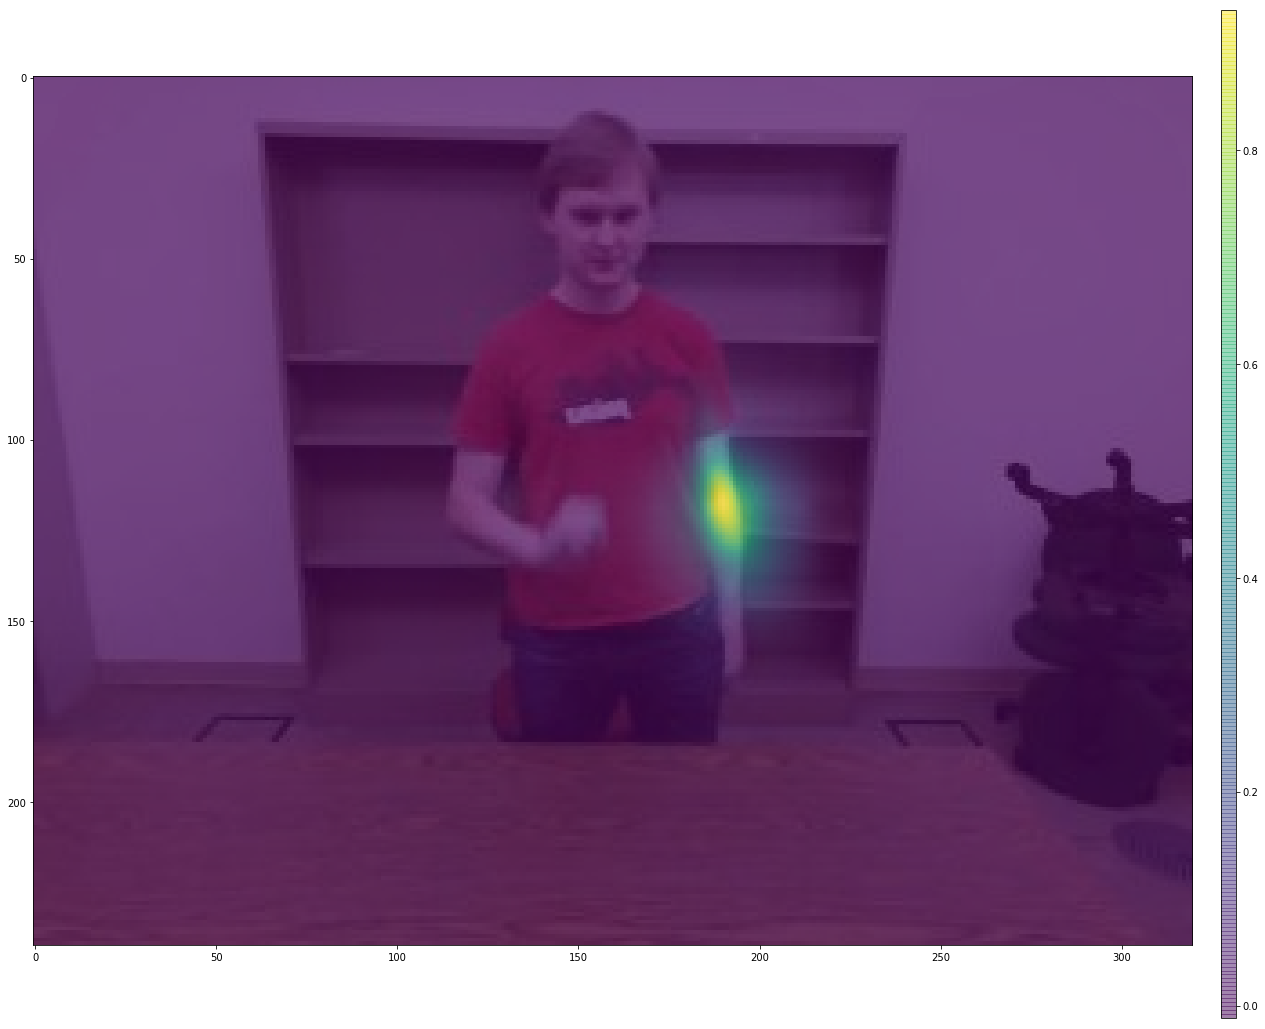

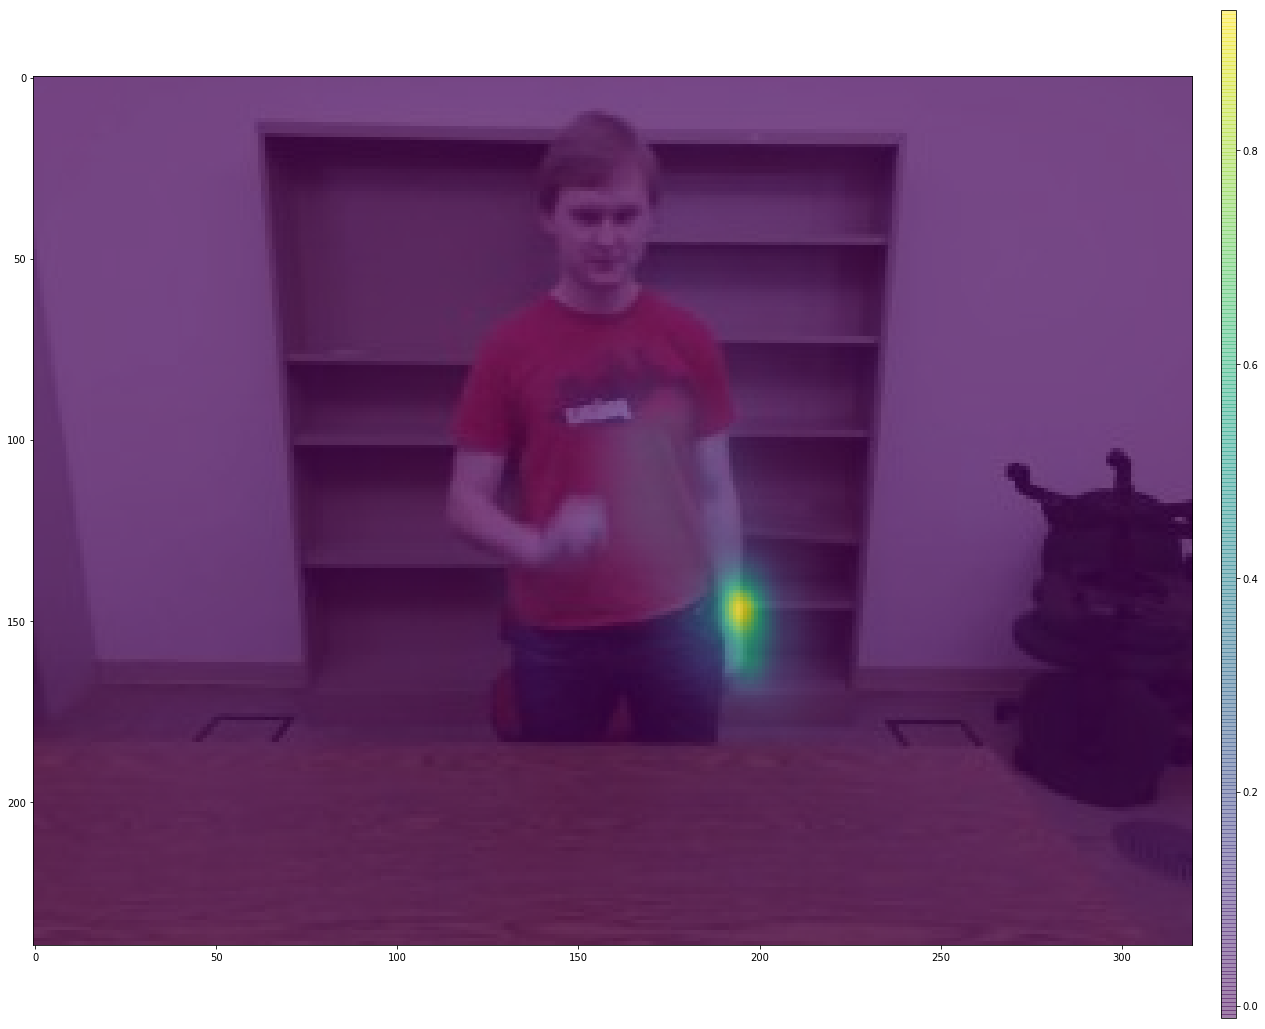

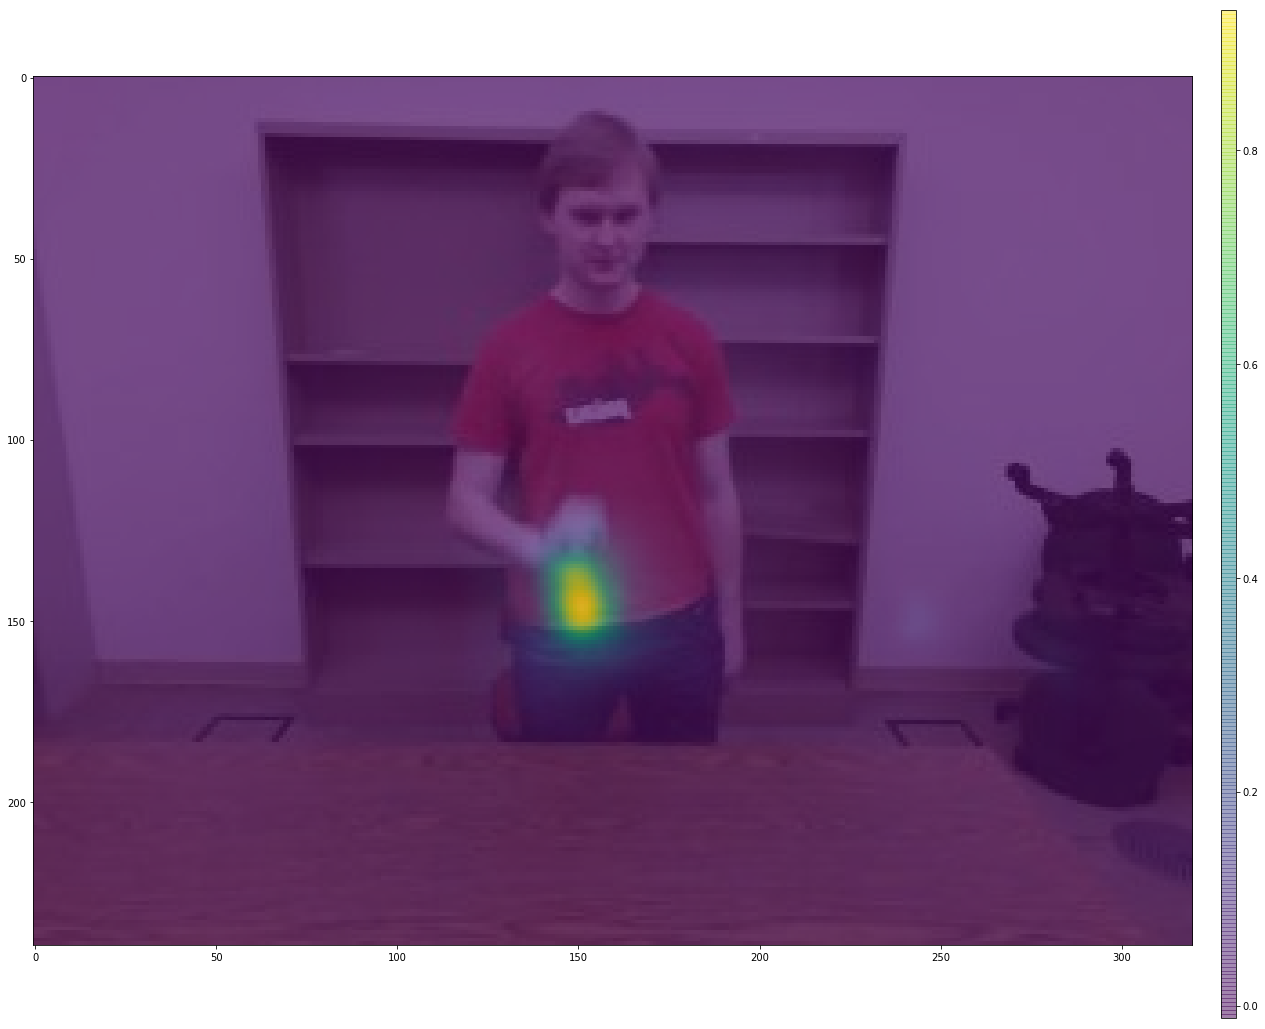

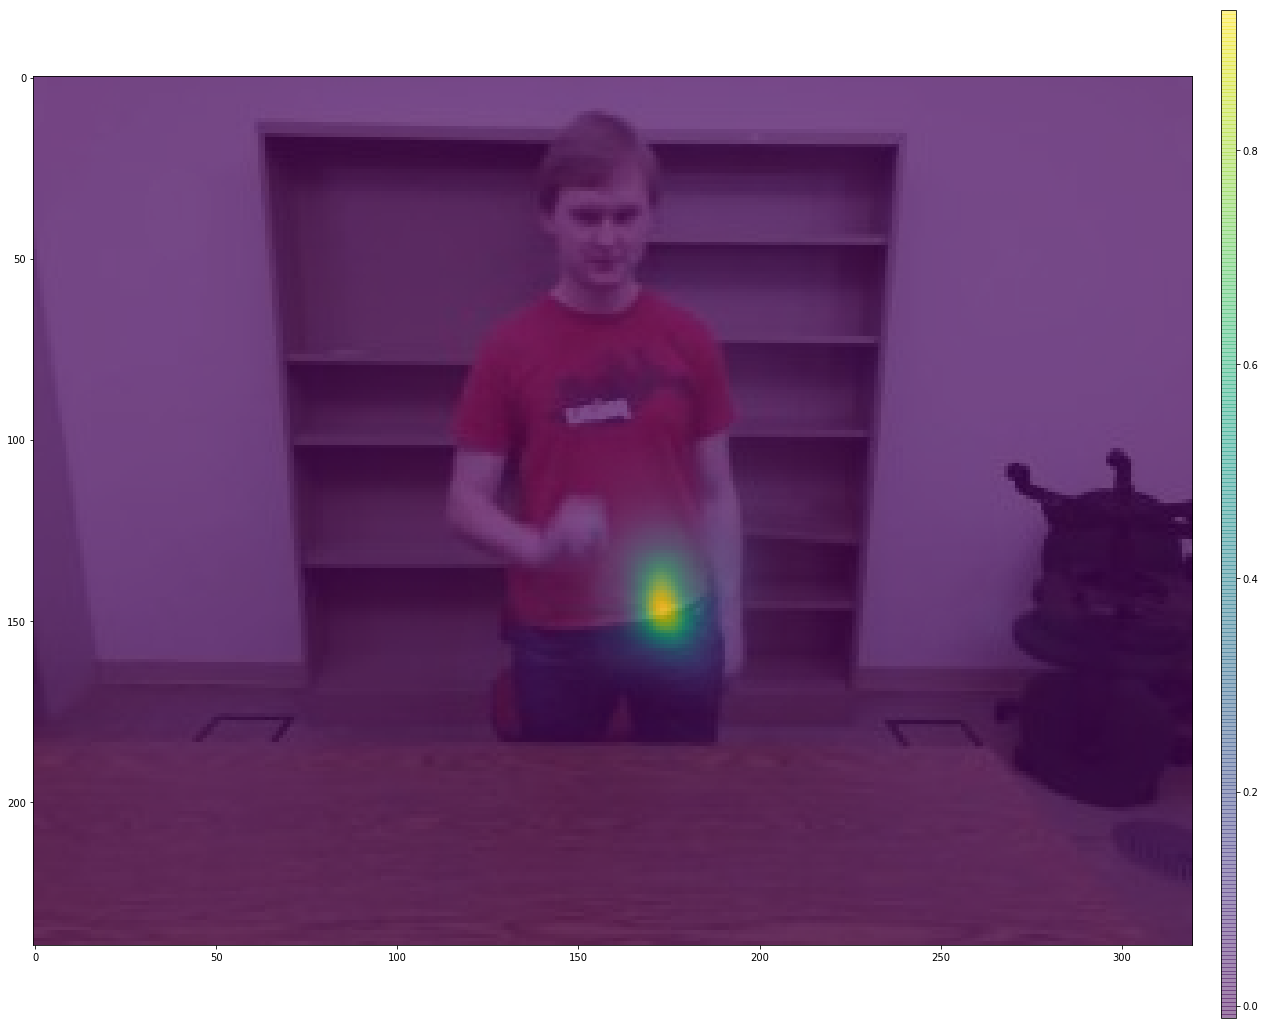

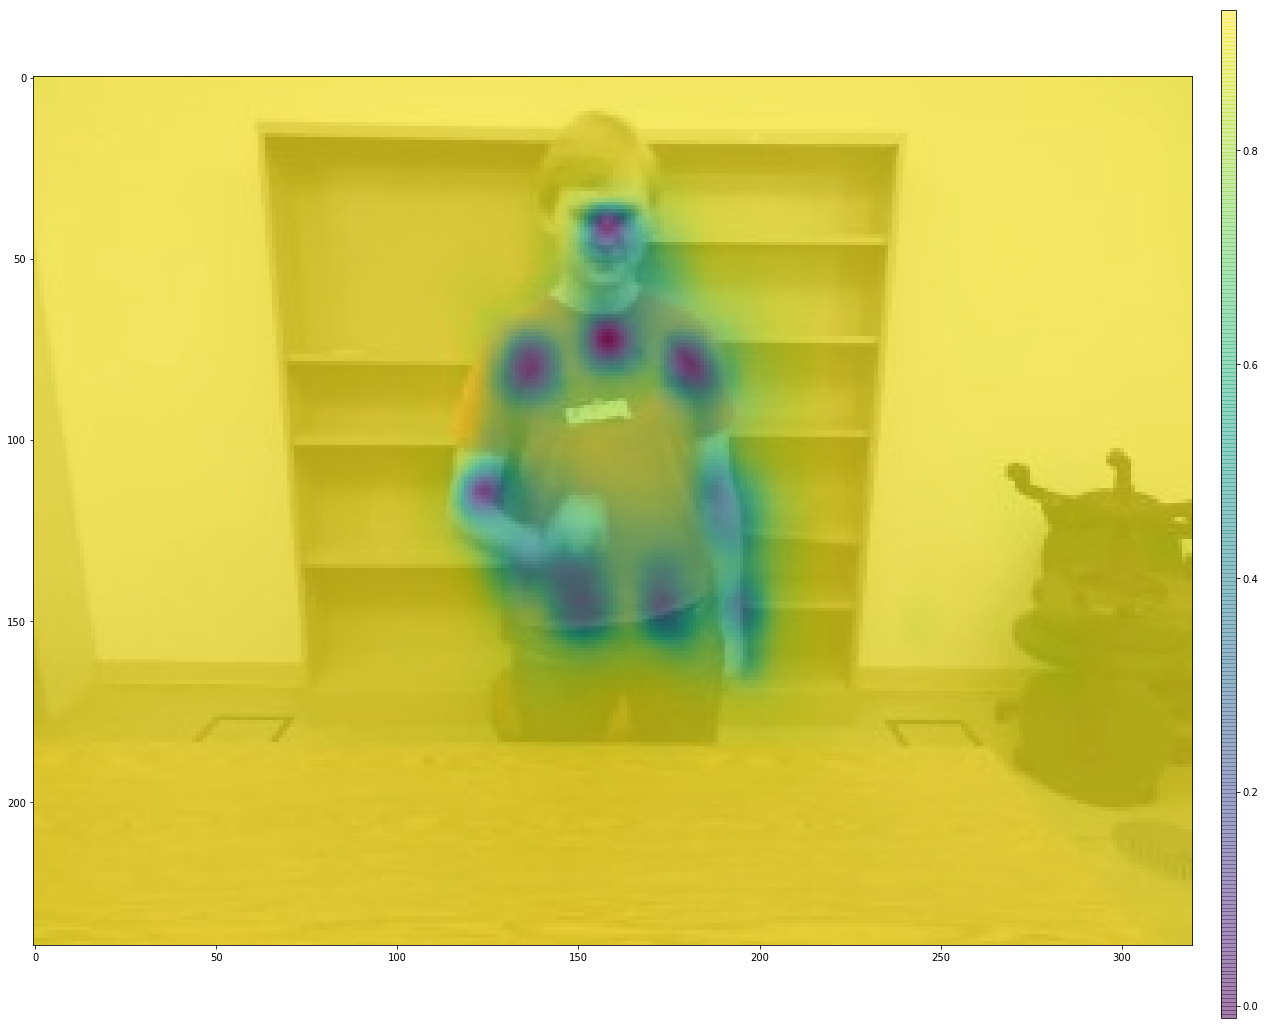

In [624]:
#1
# all_joints_map = np.max(heatmap_avg[:,:,:-1], axis=2)
# # all_joints_map = heatmap_avg[:,:,10]

# plt.imshow(oriImg[:,:,[2,1,0]])
# fig = matplotlib.pyplot.gcf()
# cax = matplotlib.pyplot.gca()
# fig.set_size_inches(20, 20)
# fig.subplots_adjust(right=0.93)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
# _ = fig.colorbar(ax2, cax=cbar_ax)


#2
for i in range(heatmap_avg.shape[2]):
    plt.figure()
    plt.imshow(oriImg[:,:,[2,1,0]])
    plt.imshow(heatmap_avg[:,:,i], alpha=.70)
    fig = matplotlib.pyplot.gcf()
    cax = matplotlib.pyplot.gca()
    fig.set_size_inches(20, 20)
    fig.subplots_adjust(right=0.93)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    _ = fig.colorbar(ax2, cax=cbar_ax)
    plt.show()

In [625]:
def show_images(images, img, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        # print("n", n)
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap=plt.get_cmap('gray'), alpha=1.0)
        if n != 2:
            plt.imshow(img, alpha=.150)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

reading /s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/test_out/o1/20160129_195318_00_Video_vfr_82_skfr_79_240x320_egg_test_True_m_hm.npy
pred shape (30, 40, 11)
gt_hm_11 shape (30, 40, 11)
loss_hm 8.168757382499129


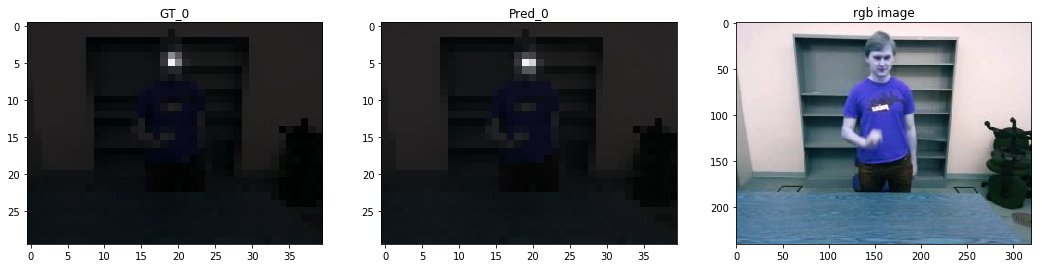

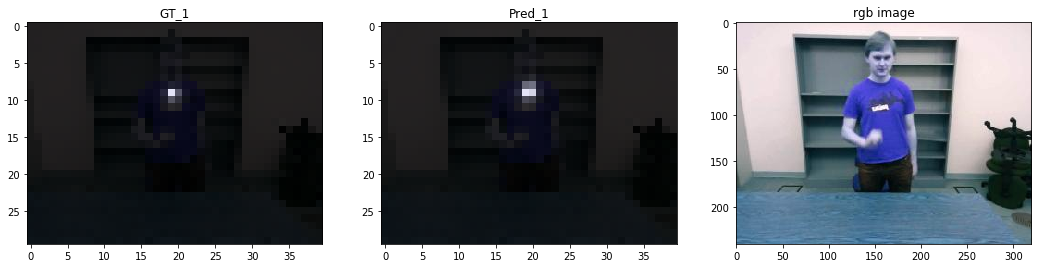

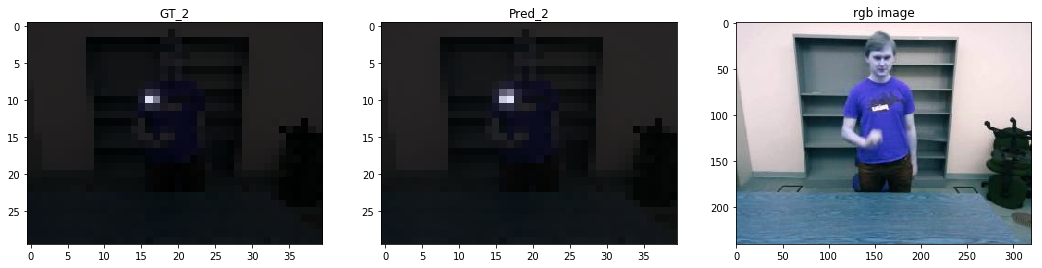

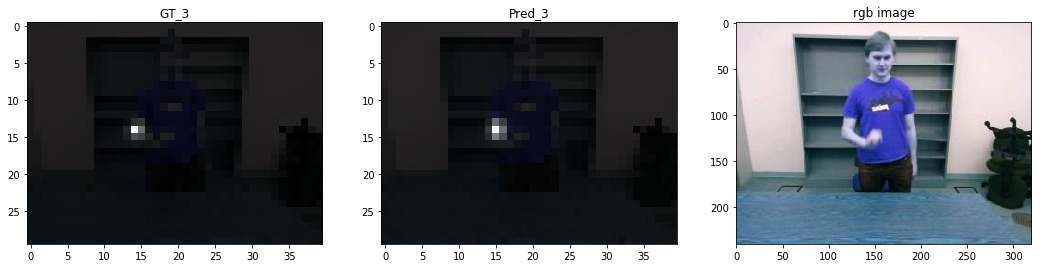

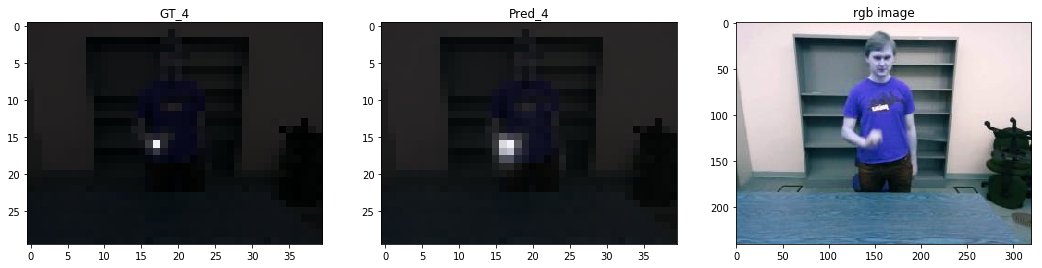

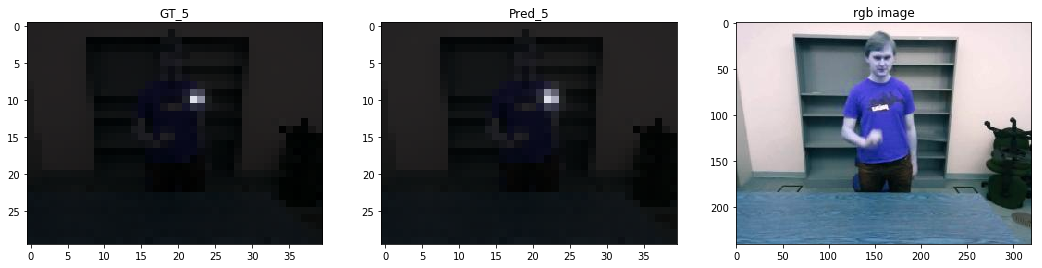

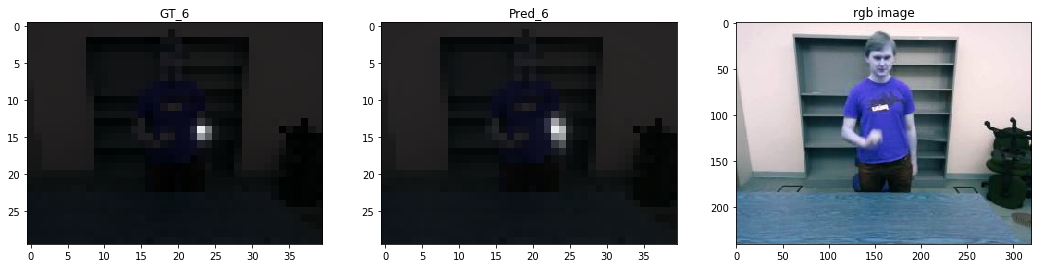

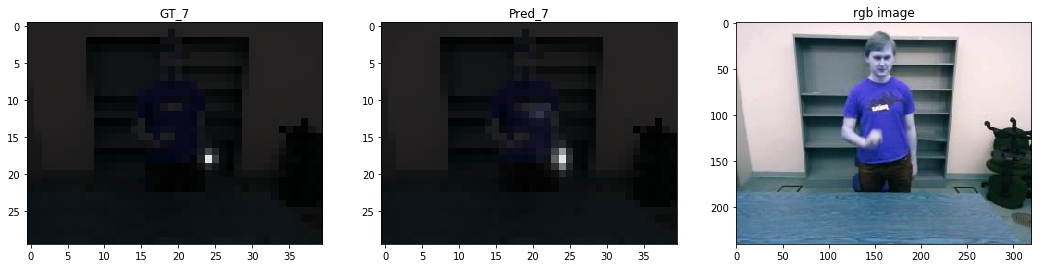

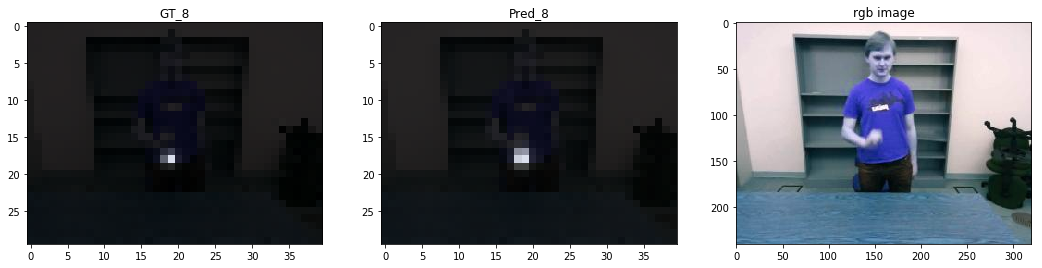

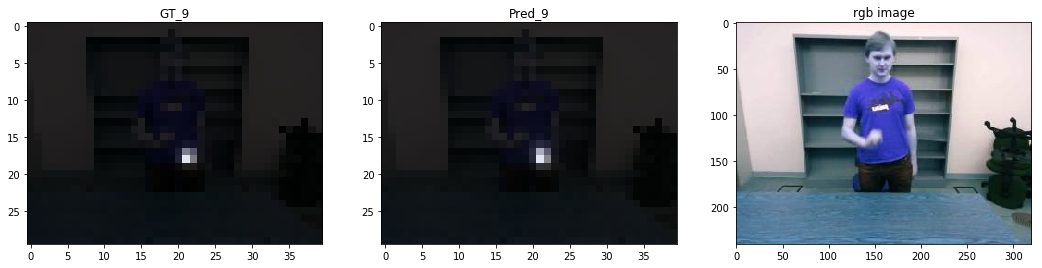

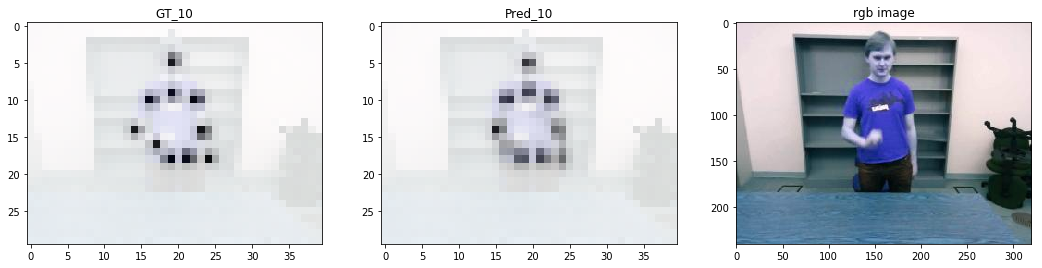

In [626]:
### calculate loss for test images
import keras.backend as K
from py_eggnog_server.py_eggnog_config import EggnogGlobalConfig
import numpy as np

def eucl_loss(x, y):
    l = K.sum(K.square(x - y))  #  / batch_size / 2
    return l

def eucl_loss_np(x, y):
    l = np.sum(np.square(x - y))  
    return l

pred_hm = np.load(hm_savefile)
print("reading", hm_savefile)
print("pred shape", pred_hm.shape)

gt_path = test_image.split(".")[0].replace("240x320", "heatmap30x40.npy")
gt_hm_19 = np.load(gt_path)

if shoulder_last:
    gt_hm_10 = gt_hm_19[:,:,EggnogGlobalConfig.eggnog19_to_eggnog_10_mapping]
    maxed_heatmap = np.max(gt_hm_10[:,:,:], axis=2)
    gt_hm_11 = np.dstack((gt_hm_10, 1 - maxed_heatmap))
#     pred_hm_11 = pred_hm[:, :, ]
else:
    gt_hm_10 = gt_hm_19[:,:,EggnogGlobalConfig.eggnog19_to_coco_10_mapping]
    maxed_heatmap = np.max(gt_hm_10[:,:,:], axis=2)
    gt_hm_11 = np.dstack((gt_hm_10, 1 - maxed_heatmap))

print("gt_hm_11 shape", gt_hm_11.shape)
zero_gt = np.zeros(gt_hm_11.shape)


# loss calc
if eggnog_testing:
#     loss_hm = eucl_loss_np(pred_hm, zero_gt)
    loss_hm = eucl_loss_np(pred_hm, gt_hm_11)
    print("loss_hm", loss_hm)

# with tf.Session() as sess:
#     # Run the init operation.
#     sess.run(loss_hm)
#     print("loss_hm", loss_hm)

# display both
test_heatmap = pred_hm
gt_heatmap = gt_hm_11

images = []  # a list containing alternated test_hm and gt_hm
titles = []  # titles for images above
len_hm = test_heatmap.shape[2]


for i in range(test_heatmap.shape[2]):
    #2 faster
    images.append(gt_heatmap[:,:,i])  #
    images.append(test_heatmap[:,:,i])  #
    images.append(oriImg)

    titles.append('GT_' + str(i))
    titles.append('Pred_' + str(i))
    titles.append('rgb image')
    
    oriImgResized = cv2.resize(oriImg, (gt_heatmap.shape[1], gt_heatmap.shape[0]), interpolation=cv2.INTER_CUBIC)
    show_images(images, oriImgResized, 1, titles)
    
    images = []
    titles = []

paf vectors for right elbow and right wrist

In [627]:
# from numpy import ma
# U = paf_avg[:,:,2] * -1
# V = paf_avg[:,:,30]
# X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
# M = np.zeros(U.shape, dtype='bool')
# M[U**2 + V**2 < 0.5 * 0.5] = True
# U = ma.masked_array(U, mask=M)
# V = ma.masked_array(V, mask=M)

# # 1
# plt.figure()
# plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
# s = 5
# Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
#                scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(20, 20)

Visualise all detected body parts. Note that we use peaks in heatmaps

In [628]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(np_branch2-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    # print("map shape", map.shape) (480, 640)
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > 2* param['thre1']))
    # print("peaks_binary.shape", peaks_binary.shape)  # (480, 640)
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    print("peaks list", peaks)
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    print("peaks scores list", peaks_with_score)
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]
    print("peaks_with_score_and_id", peaks_with_score_and_id)
    
    all_peaks.append(peaks_with_score_and_id)
    # print("all_peaks", all_peaks)
    peak_counter += len(peaks)
    
print("all_peaks", all_peaks)

peaks list [(159, 42)]
peaks scores list [(159, 42, 0.6506935507059097)]
peaks_with_score_and_id [(159, 42, 0.6506935507059097, 0)]
peaks list [(159, 73)]
peaks scores list [(159, 73, 0.6664845198392868)]
peaks_with_score_and_id [(159, 73, 0.6664845198392868, 1)]
peaks list [(137, 80)]
peaks scores list [(137, 80, 0.5786620229482651)]
peaks_with_score_and_id [(137, 80, 0.5786620229482651, 2)]
peaks list [(124, 115)]
peaks scores list [(124, 115, 0.5916594788432121)]
peaks_with_score_and_id [(124, 115, 0.5916594788432121, 3)]
peaks list [(136, 134)]
peaks scores list [(136, 134, 0.23764853738248348)]
peaks_with_score_and_id [(136, 134, 0.23764853738248348, 4)]
peaks list [(181, 79)]
peaks scores list [(181, 79, 0.5577193275094032)]
peaks_with_score_and_id [(181, 79, 0.5577193275094032, 5)]
peaks list [(190, 118)]
peaks scores list [(190, 118, 0.40630461275577545)]
peaks_with_score_and_id [(190, 118, 0.40630461275577545, 6)]
peaks list [(195, 147)]
peaks scores list [(195, 147, 0.3450491

In [629]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [630]:
# connection_all = []
# special_k = []
# mid_num = 10

# for k in range(len(mapIdx)):
#     score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
#     candA = all_peaks[limbSeq[k][0]-1]
#     candB = all_peaks[limbSeq[k][1]-1]
#     nA = len(candA)
#     nB = len(candB)
#     indexA, indexB = limbSeq[k]
#     if(nA != 0 and nB != 0):
#         connection_candidate = []
#         for i in range(nA):
#             for j in range(nB):
#                 vec = np.subtract(candB[j][:2], candA[i][:2])
#                 norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
#                 # failure case when 2 body parts overlaps
#                 if norm == 0:
#                     continue
#                 vec = np.divide(vec, norm)
                
#                 startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
#                                np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
#                 vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
#                                   for I in range(len(startend))])
#                 vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
#                                   for I in range(len(startend))])

#                 score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
#                 score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
#                 criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
#                 criterion2 = score_with_dist_prior > 0
#                 if criterion1 and criterion2:
#                     connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

#         connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
#         connection = np.zeros((0,5))
#         for c in range(len(connection_candidate)):
#             i,j,s = connection_candidate[c][0:3]
#             if(i not in connection[:,3] and j not in connection[:,4]):
#                 connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
#                 if(len(connection) >= min(nA, nB)):
#                     break

#         connection_all.append(connection)
#     else:
#         special_k.append(k)
#         connection_all.append([])

In [631]:
# # last number in each row is the total parts number of that person
# # the second last number in each row is the score of the overall configuration
# subset = -1 * np.ones((0, 20))
# candidate = np.array([item for sublist in all_peaks for item in sublist])

# for k in range(len(mapIdx)):
#     if k not in special_k:
#         partAs = connection_all[k][:,0]
#         partBs = connection_all[k][:,1]
#         indexA, indexB = np.array(limbSeq[k]) - 1

#         for i in range(len(connection_all[k])): #= 1:size(temp,1)
#             found = 0
#             subset_idx = [-1, -1]
#             for j in range(len(subset)): #1:size(subset,1):
#                 if subset[j][i/s/red/b/nobackup/data/eggnog_cpm/training_files/common_train/0618180100pm/ndexA] == partAs[i] or subset[j][indexB] == partBs[i]:
#                     subset_idx[found] = j
#                     found += 1
            
#             if found == 1:
#                 j = subset_idx[0]
#                 if(subset[j][indexB] != partBs[i]):
#                     subset[j][indexB] = partBs[i]
#                     subset[j][-1] += 1
#                     subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
#             elif found == 2: # if found 2 and disjoint, merge them
#                 j1, j2 = subset_idx
#                 print ("found = 2")
#                 membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
#                 if len(np.nonzero(membership == 2)[0]) == 0: #merge
#                     subset[j1][:-2] += (subset[j2][:-2] + 1)
#                     subset[j1][-2:] += subset[j2][-2:]
#                     subset[j1][-2] += connection_all[k][i][2]
#                     subset = np.delete(subset, j2, 0)
#                 else: # as like found == 1
#                     subset[j1][indexB] = partBs[i]
#                     subset[j1][-1] += 1
#                     subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

#             # if find no partA in the subset, create a new subset
#             elif not found and k < 17:
#                 row = -1 * np.ones(20)
#                 row[indexA] = partAs[i]
#                 row[indexB] = partBs[i]
#                 row[-1] = 2
#                 row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
#                 subset = np.vstack([subset, row])

In [632]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

NameError: name 'subset' is not defined

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9


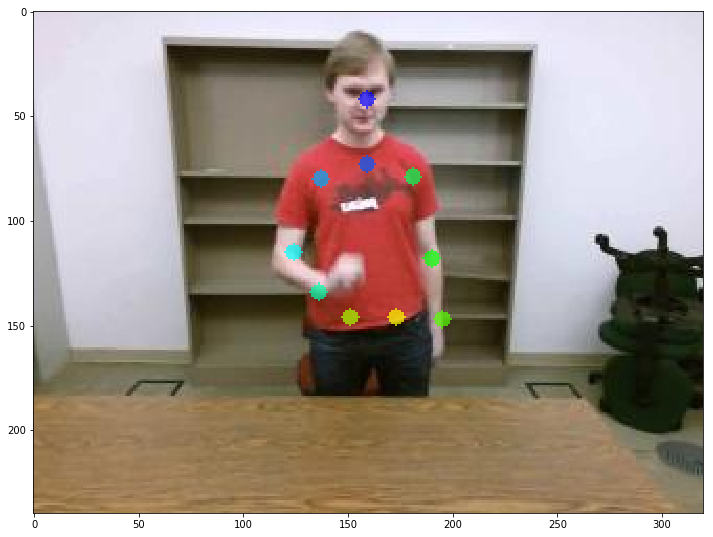

In [633]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

# print("len(all_peaks[i])", len(all_peaks[i]))

for i in range(np_branch2-1):
    print("i", i)
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

Link body parts

In [511]:
# # visualize 2
# stickwidth = 4

# for i in range(17):
#     for n in range(len(subset)):
#         index = subset[n][np.array(limbSeq[i])-1]
#         if -1 in index:
#             continue
#         cur_canvas = canvas.copy()
#         Y = candidate[index.astype(int), 0]
#         X = candidate[index.astype(int), 1]
#         mX = np.mean(X)
#         mY = np.mean(Y)
#         length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
#         angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
#         polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
#         cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
#         canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
# plt.imshow(canvas[:,:,[2,1,0]])
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(12, 12)